In [50]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit
from scipy import signal

DATA_TYPES = {'short':(2,'h'),'short-data':(2,'h'), 'unsignedshort':(2,'H'),
              'integer-data':(4,'i'), 'signedinteger':(4,'i'),
              'float-data':(4,'f'), 'double':(8,'d')}

#read WSxM header data
def wsxm_readheader(file, pos=0, inibyte=100):
    header_dict = {}
    # Find header size
    file.seek(pos, 0)
    data = file.read(inibyte)
    for ln in data.splitlines():
        hd_lst = ln.decode('ascii', errors='ignore').split(':')
        if len(hd_lst) == 2:
            if hd_lst[0] == 'Image header size':
                header_size = int(hd_lst[1])
                # print(header_size)
                break
    # read header data
    file.seek(pos, 0)
    data = file.read(header_size)#[:header_size]
    for ln in data.splitlines():
        hd_lst = ln.decode('ascii', errors='ignore').split(':')
        if len(hd_lst) == 2:
            header_dict[hd_lst[0].strip()] = hd_lst[1].strip()
    
    pos_new = pos + header_size #bytes read so far
    # print(header_dict)
    return header_dict, pos_new

#read WSxM binary image data
def wsxm_readimg(file, header_dict, pos):
    data_format = header_dict['Image Data Type']
    chan_label = header_dict['Acquisition channel']
    line_rate = float(header_dict['X-Frequency'].split(' ')[0])
    x_num = int(header_dict['Number of rows'])
    y_num = int(header_dict['Number of columns'])
    x_len = float(header_dict['X Amplitude'].split(' ')[0])
    y_len = float(header_dict['Y Amplitude'].split(' ')[0])
    z_len = float(header_dict['Z Amplitude'].split(' ')[0])
    x_dir = header_dict['X scanning direction']
    y_dir = header_dict['Y scanning direction'] #CHECK Y DIRECTIONS

    x_data = np.linspace(0, x_len, x_num, endpoint=True) if x_dir == 'Backward' else np.linspace(x_len, 0, x_num, endpoint=True)
    y_data = np.linspace(0, y_len, y_num, endpoint=True) if y_dir == 'Down' else np.linspace(y_len, 0, y_num, endpoint=True)
    xx_data, yy_data = np.meshgrid(x_data, y_data)
    
    #read binary image data
    point_length, type_code  = DATA_TYPES[data_format]
    # with open(filepath, 'rb') as file:
    file.seek(pos, 0)
    data_len = x_num*y_num*point_length
    bin_data = file.read(data_len)
    # print(data.read()[(x_num*y_num*point_length)+header_size:])
    ch_array = np.array(list(struct.iter_unpack(f'{type_code}', bin_data))).flatten()
    z_calib = z_len/(ch_array.max()-ch_array.min())
    #img data dictionary
    data_dict_chan = {'data': {'Z': z_calib*ch_array,
                               'X': xx_data.flatten(),
                               'Y':yy_data.flatten(),},
                      'header': header_dict}
    
    pos += data_len #bytes read so far
    return data_dict_chan, pos
    
# Read WSxM channel image data
def wsxm_readchan(filepath):
    file = open(f'{filepath}','rb')
    header_dict, pos = wsxm_readheader(file)
    data_dict, pos = wsxm_readimg(file, header_dict, pos)     
    return data_dict

# read *.curves file with image and f-d curves
def wsxm_readcurves(filepath):
    file = open(f'{filepath}','rb')
    header_dict, pos = wsxm_readheader(file)
    data_dict_chan, pos = wsxm_readimg(file, header_dict, pos) 
    
    data_format = header_dict['Image Data Type']
    point_length, type_code  = DATA_TYPES[data_format]
    data_dict_curv = {}
    
    while True:
        # file.seek(pos, 0)
        header_dict, pos = wsxm_readheader(file, pos=pos)     
        line_pts = int(header_dict['Number of points'])
        line_num = int(header_dict['Number of lines'])
        y_label = header_dict['Y axis text'].split('[')[0].strip()
        x_label = header_dict['X axis text'].split('[')[0].strip()
        curv_ind = int(header_dict['Index of this Curve'])
        curv_num = int(header_dict['Number of Curves in this serie'])
        
        line_order = ['approach', 'retract']
        if header_dict['First Forward'] == 'No': #CHECK THIS
            line_order = ['retract', 'approach']

        data_len = line_pts*line_num*2*point_length
        file.seek(pos, 0)
        bin_data = file.read(data_len)
        ch_array = np.array(list(struct.iter_unpack(f'{type_code}', bin_data))).flatten()
        
        data_dict_curv[curv_ind] = {'data': {x_label: ch_array[::2],
                                                  y_label: ch_array[1::2],
                                                  'Segment':np.append(line_pts * [line_order[0]],line_pts * [line_order[1]])},
                                    'header': header_dict
                                    }
        
        if curv_ind == curv_num:
            break
        else:
            pos += data_len #bytes read so far
            file.seek(pos, 0)

    data_dict = {'Channel': data_dict_chan,
                 'Curves': data_dict_curv
                }
    
    return data_dict

# Read WSxM Force volume data
def wsxm_readgsi(filepath):
    file = open(f'{filepath}','rb')
    header_dict, pos = wsxm_readheader(file)
    
    data_format = header_dict['Image Data Type']
    chan_label = header_dict['Acquisition channel']
    line_rate = float(header_dict['X-Frequency'].split(' ')[0])
    x_num = int(header_dict['Number of rows'])
    y_num = int(header_dict['Number of columns'])
    chan_num = int(header_dict['Number of points per ramp'])
    x_len = float(header_dict['X Amplitude'].split(' ')[0])
    y_len = float(header_dict['Y Amplitude'].split(' ')[0])
    z_len = float(header_dict['Z Amplitude'].split(' ')[0])
    chan_adc2v = float(header_dict['ADC to V conversion factor'].split(' ')[0])
    # x_dir = header_dict['X scanning direction']
    # y_dir = header_dict['Y scanning direction'] #CHECK Y DIRECTIONS

    x_data = np.linspace(0, x_len, x_num, endpoint=True) #if x_dir == 'Backward' else np.linspace(x_len, 0, x_num, endpoint=True)
    y_data = np.linspace(0, y_len, y_num, endpoint=True) #if y_dir == 'Down' else np.linspace(y_len, 0, y_num, endpoint=True)
    xx_data, yy_data = np.meshgrid(x_data, y_data)
    
    #read binary image data
    point_length, type_code  = DATA_TYPES[data_format]
    # with open(filepath, 'rb') as file:
    file.seek(pos, 0)
    data_len = x_num*y_num*point_length
    pos += data_len #skip first topo image
    ch_array = np.empty(0) #initialize channel data array
    for i in range(1, chan_num+1):
        file.seek(pos, 0)
        bin_data = file.read(data_len)
        # print(data.read()[(x_num*y_num*point_length)+header_size:])
        ch_array_temp = np.array(list(struct.iter_unpack(f'{type_code}', bin_data))).flatten()
        # print(ch_array_temp.min(), ch_array_temp.max())
        # if i == 0:
        #     z_calib = z_len/(ch_array_temp.max()-ch_array_temp.min())
        # else:
        ch_array = np.append(ch_array, ch_array_temp*chan_adc2v)
        pos += data_len #next image
    # print(z_calib, chan_adc2v, z_len)
    
    #img data dictionary
    data_dict_chan = {'data': {'Z': ch_array,
                               'X': xx_data.flatten(),
                               'Y':yy_data.flatten(),},
                      'header': header_dict}
    
    pos += data_len #bytes read so far    
    return data_dict_chan


-1.628419136 0.539551168 2.167970304


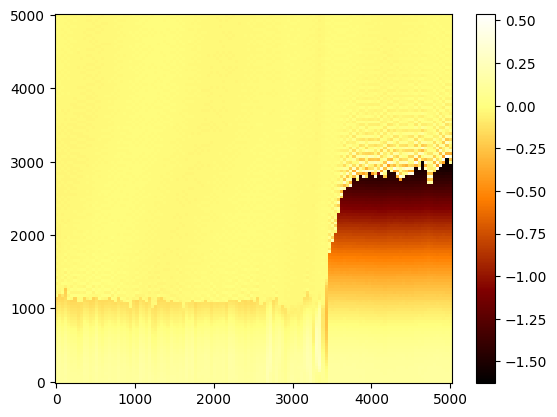

{'Image header size': '30142',
 'Set Point': '0.1486 V',
 'Signal Gain': '1',
 'Topography Bias': '0 mV',
 'X Amplitude': '5000 nm',
 'X Offset': '-7075.36 nm',
 'X-Frequency': '0.216 Hz',
 'Y Amplitude': '5000 nm',
 'Y Offset': '-6050.27 nm',
 'Z Gain': '10',
 'Z Offset': '761.621 nm',
 'Frq. Scan Sensitivity': '0.098 kHz/V',
 'Gain in': '10',
 'Gain out X': '2',
 'Resonance frequency': '68720 Hz',
 'Acquisition channel': 'Normal force',
 'Acquisition primary channel': 'Channel 1',
 'ADC to V conversion factor': '0.000305176',
 'Channel is inverted': 'No',
 'Conversion factor 0 for input channel': '1 V',
 'Conversion factor 0 for output channel': '1 nm',
 'Conversion factor 1 for output channel': '1 V',
 'Conversion offset 0 for input channel': '0 V',
 'Conversion offset 0 for output channel': '0 nm',
 'Conversion offset 1 for output channel': '0 V',
 'DAC to V conversion factor': '0.000305176',
 'Feedback on between points': 'No',
 'Feedback on between ramps': 'Yes',
 'Feedback on du

In [63]:
#filepath = 'data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15'
#filepath = 'data/interdigThiols_tipSi3nN_b_0026.f.dy.top'
filepath = 'data/interdigThiols_tipSi3nN_b_0026.fb.ch1.gsi' #ff,fb,bb,bf:1st letter=x dir,2nd letter=z dir
#filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'

# file = open(f'{filepath}','rb')
# header_dict, pos = wsxm_readheader(file)
data_dict = wsxm_readgsi(filepath)
im_data = data_dict['data']

# data_dict = wsxm_readchan(filepath)
# im_data = data_dict['data']

# test_data = wsxm_readcurves(filepath)
#plot AFM Z image
# im_data = test_data['Channel']['data']
xx = im_data['X'].reshape(128,128)
yy = im_data['Y'].reshape(128,128)
zz = im_data['Z'].reshape(128,128,128)[:,:,10]#1st index:xy sections, 2nd index:xz sections, 3rd index: yz sections
#TODO: change and check how forward backward in z (or x) can be consistently plotted
print(zz.min(),zz.max(), zz.max()-zz.min())
plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()
# acq_pt = test_data['Curves'][3]['header']['Acquisition point'].strip('()').split(',')
# plt.scatter(float(acq_pt[0]), float(acq_pt[1]),color = 'green')
plt.show()
header_dict
# #plot Curves
# test_df = pd.DataFrame.from_dict(test_data['Curves'][3]['data'])
# sns.lineplot(data=test_df, x="Z", y="Excitation frequency", hue="Segment")
# plt.show()

In [121]:
def get_psd(filepath):
    im_data, head_data = read_wsxm_chan(filepath)
    print(head_data)
    #plot AFM Z image
    xx = im_data['X'].reshape(128,128)
    yy = im_data['Y'].reshape(128,128)
    zz = im_data['Z'].reshape(128,128)
    plt.pcolormesh(xx,yy,zz, cmap='afmhot')
    plt.colorbar()
    plt.show()
    
    #Obtain Power Spectral Density of data
    #sample_rate = 2*num_pts*float(head_data['X-Frequency'].split(' ')[0])
    sample_rate = float(head_data['Sampling frequency'].split(' ')[0])
    freq_array, z_pow = signal.periodogram(zz, sample_rate, scaling='density') #power spectral density
    z_pow_avg = np.average(z_pow, axis=0) #averaged
    freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
    freq_array_shifted = freq_array + freq_drive
    # plt.plot(freq_array, z_pow_avg)
    # plt.show()

    z = im_data['Z']
    z_rms = np.sqrt(z.dot(z)/z.size)
    
    return freq_array_shifted, z_pow_avg, z_rms


#Lorentzian fit
# y0 = white noise offset, f0 = resonance freq, w = Full width at half maximum, A = area
def lorentzian(f, y0,f0, w, A):
    return y0 + ((2*A/np.pi) * (w / ( w**2 + 4*( f - f0 )**2)))

{'Image header size': '3031', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

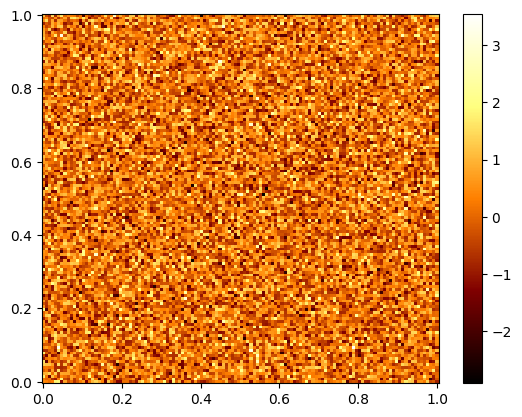

{'Image header size': '3037', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

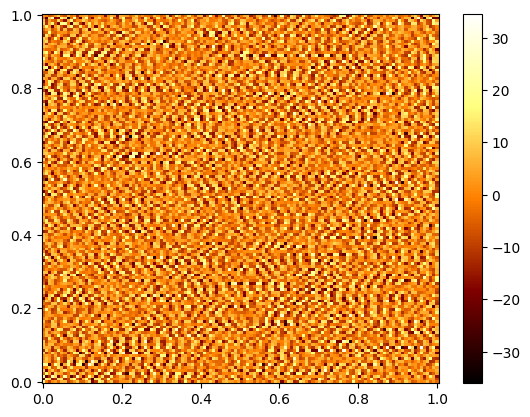

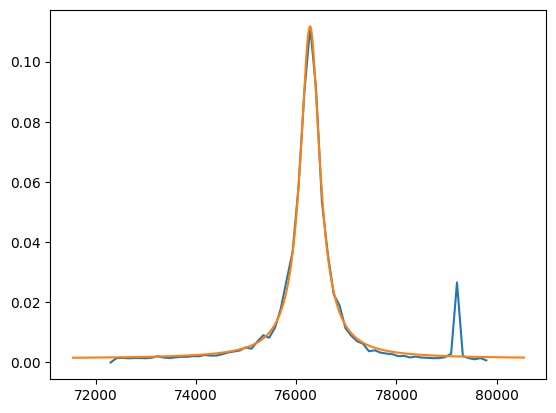

{'offset': 0.0012934139192533319, 'resonance freq': 76274.15433510602, 'fwhm': 473.8767061692985, 'area': 82.11451304229297, 'Q factor': 160.9578047245397}


In [2]:
files = ['data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15', 
         'data/20240202_laser_on_128pts_58lps_0003.f.dy.ch15']
data_dict = {}
rms_min = np.inf
for file in files:
    data_dict[file] = {}
    data_dict[file]['Frequency'], data_dict[file]['PSD'], data_dict[file]['Z rms'] = get_psd(file)
    if data_dict[file]['Z rms'] < rms_min:
        rms_min = data_dict[file]['Z rms']
        off_file = file

on_file = [n for n in files if n != off_file][0]
data_dict[off_file]['Label'] = 'Laser ON'
data_dict[on_file]['Label'] = 'Laser OFF'

#plot data images
# for file in files:
#     plt.plot(data_dict[file]['Frequency'], data_dict[file]['PSD'], label = data_dict[file]['PSD'])
# plt.show()
    

#z_pow = 2*(z_fftx_avg[64:]**2)/(15000*128)
#freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
#freq_array_real = freq_array_shift[64:] + freq_drive
freq_final = data_dict[on_file]['Frequency']
psd_final = data_dict[on_file]['PSD'] - data_dict[off_file]['PSD']
plt.plot(freq_final, psd_final)
#plt.show()

#guess = [0, 76000, 2000, 100000]
y_guess = psd_final.min()
f_guess = freq_final[psd_final.argmax()]
w_guess = 2*np.abs(freq_final[(np.abs(psd_final - psd_final.max()/2)).argmin()]-f_guess)
A_guess = np.pi*w_guess*psd_final.max()/2
guess = [y_guess, f_guess, w_guess, A_guess] #y0,f0,w,A
#fit
popt, pcov = curve_fit(lorentzian, freq_final,psd_final,
                    p0=guess, bounds=(0,np.inf))
#print(np.linalg.cond(pcov))
params = ['offset','resonance freq', 'fwhm', 'area']
fit_dict = dict(zip(params, popt))
fit_dict['Q factor'] = fit_dict['resonance freq']/fit_dict['fwhm']

#plot fit
f_min, f_max = freq_final.min(), freq_final.max()
f_ext = 0.1*(f_max-f_min)
freq_fit_range = np.linspace(f_min-f_ext, f_max+f_ext, 100000)
plt.plot(freq_fit_range,lorentzian(freq_fit_range, *popt))
plt.show()

print(fit_dict)

In [37]:
# Q = head_data['Quality factor (Q)']
k_cant = 2 # N/m
T = 300 #K
kb = 1.380649e-23 #J/K
V_rms = np.sqrt(fit_dict['area'])
corr_fac = 4/3 #Butt-Jaschke correction for thermal noise
sens = np.sqrt(corr_fac*kb*T/k_cant)/V_rms/1e-9 #nm/V 
print(V_rms, sens)
print(np.sqrt(data_dict[on_file]['Z rms']**2 - data_dict[off_file]['Z rms']**2))
# z = im_data['Z']
# print(np.sqrt(z.dot(z)/z.size))

9.061705857193388 0.005798914136715741
9.421556156513725


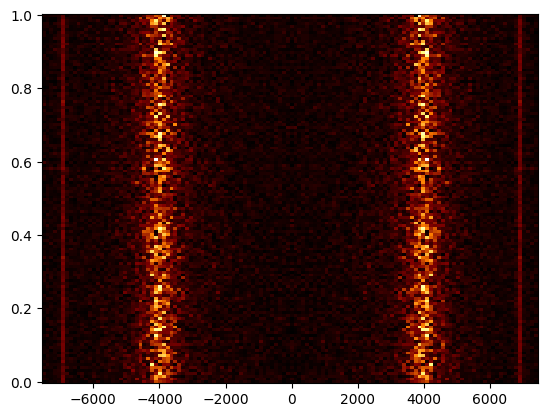

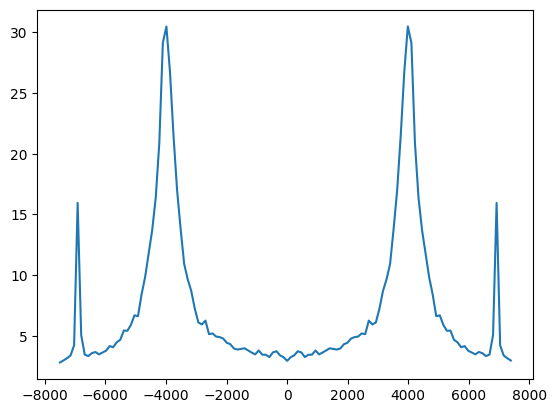

In [6]:
# #1D Fourier Transform of image and average along Y axis.
# z_fftx = np.abs(np.fft.fft(zz))
# z_fftx_shift = np.fft.fftshift(z_fftx)
# z_fftx_avg = np.average(z_fftx_shift, axis=0)

# num_pts = len(z_fftx_avg)
# sample_rate = 2*num_pts*float(head_data['X-Frequency'].split(' ')[0])
# freq_array = np.fft.fftfreq(len(z_fftx_avg), 1 / sample_rate)
# freq_array_shift = np.fft.fftshift(freq_array)
# ff, _ = np.meshgrid(freq_array_shift, freq_array_shift)
# plt.pcolormesh(ff, yy, z_fftx_shift, cmap='afmhot')
# plt.show()
# plt.plot(freq_array_shift, z_fftx_avg)
# plt.show()